# Fakenews detection
Karolina Mączka, Tymoteusz Urban

In [98]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Getting to know the data

In [99]:
df=pd.read_csv('PreProcessedData.csv', header=0, sep=',')

In [100]:
df.head()

,Unnamed: 0,title,text,Ground Label
0,0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69045 entries, 0 to 69044
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    69045 non-null  int64 
 1   title         68365 non-null  object
 2   text          68978 non-null  object
 3   Ground Label  69045 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


In [102]:
# porządek
df = df[['title', 'text', 'Ground Label']]
df.rename(columns={'Ground Label': 'label'}, inplace=True)
df.head()

,title,text,label
0,Ann Coulter Make Believes She Has ‘Gay Friend...,"It s hard to believe, but Donald Trump does ha...",fake
1,Rating: Moody‘s verbessert Ausblick für Russla...,bankensektor Der russische Staat werde die Ban...,fake
2,CAN WE ADD DIRTY MONEY ‘LAUNDERING’ To The Oba...,A member of the House Intelligence Committee i...,fake
3,Republicans on Obamacare repeal: 'We're going ...,WASHINGTON (Reuters) - House of Representative...,true
4,"Trump, on possible DACA deal, says border wall...",WASHINGTON (Reuters) - U.S. President Donald T...,true


In [103]:
df['label'].value_counts()

fake    42159
true    26886
Name: label, dtype: int64

## Train test split

In [104]:
# Rozdzielamy zbiory do trenowania i testowania
X_rest, X_test, y_rest, y_test = train_test_split(df[['title', 'text']], df['label'], test_size=0.30, random_state=42)

In [105]:
y_rest.value_counts()

fake    29459
true    18872
Name: label, dtype: int64

In [106]:
X_train, X_validate, y_train, y_validate = train_test_split(X_rest, y_rest, test_size=0.30, random_state=42)

In [107]:
print(y_train.value_counts())
print(y_validate.value_counts())

fake    20645
true    13186
Name: label, dtype: int64
fake    8814
true    5686
Name: label, dtype: int64


stosunek ilości fake do true wszędzie jest taki sam, więc możemy przyjąć że jest to dobre rozdzielenie danych

In [116]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_df.to_csv('training_data.csv', index=False)

In [28]:
testing_df = pd.concat([X_test, y_test], axis=1)
testing_df.to_csv('testing_data.csv', index=False)

In [29]:
# zapisanie ramki do walidacji
validate_df = pd.concat([X_validate, y_validate], axis=1)
validate_df.to_csv('fakenws_validation.csv', index=False)
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14500 entries, 55024 to 57779
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   14368 non-null  object
 1   text    14486 non-null  object
 2   label   14500 non-null  object
dtypes: object(3)
memory usage: 453.1+ KB


In [154]:
df2 = pd.concat([X_train, y_train], axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33831 entries, 17623 to 8544
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33497 non-null  object
 1   text    33800 non-null  object
 2   label   33831 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


## Data Preprocessing

### NaNs

In [156]:
# Jest bardzo mało nulli więc możemy się ich pozbyć
df2.dropna(inplace = True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33466 entries, 17623 to 8544
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   33466 non-null  object
 1   text    33466 non-null  object
 2   label   33466 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


In [157]:
# transformer function
def handleNa(df):
    df.dropna(inplace=True)
    print('nans deleted')
    return df

### Combine columns

Z racji, że będziemy analizować same słowa, łączymy kolumny title i tekst - dla naszego modelu nie będzie miało znaczenia z której kolumny pochodzą

In [152]:
df2.loc[8102]

text     THE GUY WHO Punched “Moldylocks” Speaks Out Ab...
label                                                 fake
Name: 8102, dtype: object

In [158]:
df2['text'] = df2[['title', 'text']].apply(" ".join, axis=1)

In [151]:
df2.loc[8102]['text']

'THE GUY WHO Punched “Moldylocks” Speaks Out About Violent Antifa Female With A Bottle [VIDEO] Nathan Domingo is the founder of  Identity Europa  and is the guy who was seen by millions of viewers punching a female Antifa thug the media tried to portray as a helpless woman that just happened to be in the area when fighting broke out at a free speech rally in Berkeley, CA on April 16th.The last time these two group clashed, the Trump supporters were seriously outnumbered. This time was a different story. Trump supporters came prepared for the unprovoked attacks of these hate groups and took them to task. With all the violence that happened yesterday, leftist media outlets seemed to be obsessed with reporting on the video that was taken of an alleged Trump supporter who punched an antifa female who was part of the violent group  Oak Roots Collective  that traveled to Berkeley to confront Trump supporters and shut down their right to free speech.Here s the video. At the 18 second mark you

In [149]:
df2 = df2.drop(columns='title')

In [153]:
df2.head()

,text,label
17623,In the Western World Respect for Law No Longer...,fake
61073,"WATCH: President Obama Unleashes On Trump, Sa...",fake
8102,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,fake
67016,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,fake
67779,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,fake


In [162]:
# transformer function
def combineColumns(df):
    df['text'] = df[['title', 'text']].apply(" ".join, axis=1)
    df = df.drop(columns='title')
    print('columns combined')
    return df

### Outliers

In [ ]:
import matplotlib.pyplot as plt

(array([3.3058e+04, 3.3800e+02, 4.4000e+01, 1.4000e+01, 2.0000e+00,
        1.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.90000e+01, 1.43610e+04, 2.87030e+04, 4.30450e+04, 5.73870e+04,
        7.17290e+04, 8.60710e+04, 1.00413e+05, 1.14755e+05, 1.29097e+05,
        1.43439e+05]),
 <BarContainer object of 10 artists>)

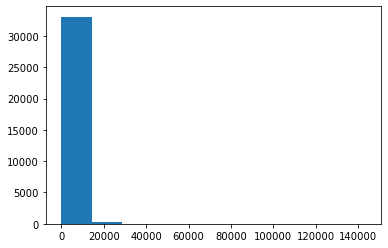

In [159]:
df2['textlength'] = df2['text'].apply(len)
plt.hist(df2['textlength'])

In [160]:
print(df2[(df2['textlength'] > 40000)].count())
df2[(df2['textlength'] > 40000)].head()

title         32
text          32
label         32
textlength    32
dtype: int64


,title,text,label,textlength
12641,Re: Why Are So Many People Choosing To Leave T...,Re: Why Are So Many People Choosing To Leave T...,fake,115924
63859,Re: Why Is Obama Threatening Russia With World...,Re: Why Is Obama Threatening Russia With World...,fake,97429
21862,Benny Morris’s Untenable Denial of the Ethnic ...,Benny Morris’s Untenable Denial of the Ethnic ...,fake,92823
58778,President-Elect Donald Trump's First Televised...,President-Elect Donald Trump's First Televised...,fake,41697
18039,Re: The Velocity Of Money In The U.S. Falls To...,Re: The Velocity Of Money In The U.S. Falls To...,fake,43623


In [161]:
# Wyrzucamy bardzo dlugie teksty (ponad 40000 znaków)
df2 = df2[(df2['textlength'] < 40000)]
df2.drop(columns='textlength')

,title,text,label
17623,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
61073,"WATCH: President Obama Unleashes On Trump, Sa...","WATCH: President Obama Unleashes On Trump, Sa...",fake
8102,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,fake
67016,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,fake
67779,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,fake
...,...,...,...
59264,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,fake
57858,Russia denies its planes killed civilians in S...,Russia denies its planes killed civilians in S...,true
63057,Hungary’s “Wall” Versus the U.S. “Wall”,Hungary’s “Wall” Versus the U.S. “Wall” Op-Ed ...,fake
61429,Pastor Caught Trump’s Spiritual Advisor Steal...,Pastor Caught Trump’s Spiritual Advisor Steal...,fake


In [121]:
#transformer function
def removeOutliers(df):
    df['textlength'] = df['text'].apply(len)
    df = df[df['textlength'] < 40000]
    df = df.drop('textlength')
    print('outliers removed')
    return df

### Removing stopwords

In [32]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tymek\AppData\Roaming\nltk_data...


In [33]:
#stopword removal
stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
def remove_stopwords(s):
    s = [lemmatizer.lemmatize(word.lower()) for word in s if not word.lower() in stop]
    return s

In [34]:
#punctuation removal
def remove_punctuations(s):
    s = re.sub(r'[^\w\s]', '', s)
    return s

In [23]:
df2['text'] = df2['text'].apply(remove_punctuations)
df2['text'] = df2['text'].apply(word_tokenize)

In [25]:
df2['text'] = df2['text'].apply(remove_stopwords)

In [36]:
def list2string(text):
    text = " ".join(wrd for wrd in text)
    return text

In [27]:
df3 = df2.copy()

In [29]:
df3["text"] = df3["text"].apply(list2string)
df3.head()

,title,text,label
17623,western world respect law longer exists,western world respect law longer exists two im...,fake
61073,watch president obama unleashes trump say terr...,interview cbs face nation sunday morning presi...,fake
8102,guy punched moldylocks speaks violent antifa f...,nathan domingo founder identity europa guy see...,fake
67016,say amazon tell customer forced federal govern...,come limiting free speech nothing lawless gove...,fake
67779,antigun zealot katie couric hit 12 million def...,little miss sunshine fooled lot people year be...,fake


In [122]:
# transformer function
def removeStopwords(df):
    df['text'] = df['text'].apply(remove_punctuations)
    print('punct remove')
    df['text'] = df['text'].apply(word_tokenize)
    print('words rokenized')
    df['text'] = df['text'].apply(remove_stopwords)
    print('stopwords removed')
    df['text'] = df['text'].apply(list2string)
    return df

### Extracting english

In [38]:
def deleteUrl(text):
    return re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)

In [35]:
# usuwamy linki i puste teksty
df3['text'] = df3['text'].apply(deleteUrl)
df3['textlength'] = df3['text'].apply(len)

In [40]:
# tworzymy krótszą kolumnę do analizy języka
def shortenText(text):
    return text[:60]

In [ ]:
df3['shorttext'] = df3['text'].apply(shortenText)

In [ ]:
df3[df3['shorttext'].apply(len) < 10]

In [ ]:
# usuwamy teksty które mają mniej niż 10 znaków - wszystkie to były typu 'watch this (some url)'
df3 = df3[df3['shorttext'].apply(len) > 10]

In [38]:
df3.head()

,title,text,label,textlength,shorttext
17623,western world respect law longer exists,western world respect law longer exists two im...,fake,237,western world respect law longer exists two im...
61073,watch president obama unleashes trump say terr...,interview cbs face nation sunday morning presi...,fake,1025,interview cbs face nation sunday morning presi...
8102,guy punched moldylocks speaks violent antifa f...,nathan domingo founder identity europa guy see...,fake,1310,nathan domingo founder identity europa guy see...
67016,say amazon tell customer forced federal govern...,come limiting free speech nothing lawless gove...,fake,940,come limiting free speech nothing lawless gove...
67779,antigun zealot katie couric hit 12 million def...,little miss sunshine fooled lot people year be...,fake,3260,little miss sunshine fooled lot people year be...


In [39]:
df4 = df3.copy()

In [ ]:
from langdetect import detect

In [41]:
df4['lang'] = df4['shorttext'].apply(detect)

In [42]:
# robimy model który będzie wykrywał po angielsku
df4 = df4[df4['lang']=='en']

In [44]:
df4 = df4[['text', 'label']].reset_index(drop=True)
df4

,title,text,label
0,western world respect law longer exists,western world respect law longer exists two im...,fake
1,watch president obama unleashes trump say terr...,interview cbs face nation sunday morning presi...,fake
2,guy punched moldylocks speaks violent antifa f...,nathan domingo founder identity europa guy see...,fake
3,say amazon tell customer forced federal govern...,come limiting free speech nothing lawless gove...,fake
4,antigun zealot katie couric hit 12 million def...,little miss sunshine fooled lot people year be...,fake
...,...,...,...
29292,state attorney lied baltimore police probable ...,marilyn mosby held press conference today said...,fake
29293,russia denies plane killed civilian syria deir...,moscow reuters russia defence ministry denied ...,true
29294,hungary wall versus u wall,oped catherine j frompovich currently european...,fake
29295,pastor caught trump spiritual advisor stealing...,seems donald trump spiritual advisor exactly e...,fake


In [123]:
#transformer function
def dropLanguages(df):
    df['text'] = df['text'].apply(deleteUrl)
    df['shorttext'] = df['text'].apply(shortenText)
    df = df[df['shorttext'].apply(len) > 10]
    df['lang'] = df['shorttext'].apply(detect)
    df = df[df['lang']=='en']
    df = df.drop(columns=['shorttext', 'lang'])
    print('languages droped')
    return df

In [45]:
# żeby zapisać dane
df4.to_csv('train_data.csv', index=False)

In [2]:
df4 = pd.read_csv('train_data.csv')

In [46]:
X_train2 = df4[['text']]

In [50]:
# Bag of words - liczba wystąpień każdego słowa w danym tekście
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train2)

In [53]:
# Zamiana częstości w częstotliwość wystąpień
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [52]:
X_train_tfidf.shape

(29297, 10089649)

## Pipeline

In [125]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

na_transformer = FunctionTransformer(handleNa)
column_transformer = FunctionTransformer(combineColumns)
outliers_transformer = FunctionTransformer(removeOutliers)
stopwords_transformer = FunctionTransformer(removeStopwords)
language_transformer = FunctionTransformer(dropLanguages)


pipe = Pipeline([
    ("na", na_transformer),
    ('columns', column_transformer),
    ('outliers', outliers_transformer),
    ("stopwords", stopwords_transformer),
    ("language", language_transformer),
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

In [117]:
train = pd.read_csv('training_data.csv', index_col=False)

In [118]:
train

,title,text,label
0,In the Western World Respect for Law No Longer...,In the Western World Respect for Law No Longer...,fake
1,"WATCH: President Obama Unleashes On Trump, Sa...",During an interview on CBS s Face the Nation S...,fake
2,THE GUY WHO Punched “Moldylocks” Speaks Out Ab...,Nathan Domingo is the founder of Identity Eur...,fake
3,SAY WHAT? AMAZON TELLS CUSTOMER THEY WERE FORC...,"When it comes to limiting our free speech, not...",fake
4,ANTI-GUN Zealot KATIE COURIC Hit With $12 MILL...,Little Miss Sunshine has fooled a lot of peo...,fake
...,...,...,...
33826,STATE’S ATTORNEY LIED: BALTIMORE POLICE HAD PR...,Marilyn Mosby held a press conference today in...,fake
33827,Russia denies its planes killed civilians in S...,MOSCOW (Reuters) - Russia s Defence Ministry d...,true
33828,Hungary’s “Wall” Versus the U.S. “Wall”,Op-Ed by Catherine J. Frompovich\r\nCurrently ...,fake
33829,Pastor Caught Trump’s Spiritual Advisor Steal...,It seems that Donald Trump s spiritual advisor...,fake


In [126]:
train_piped = pipe.fit_transform(train)

nans deleted
outliers removed
punct remove


<ipython-input-122-9bc3231ffbfd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(remove_punctuations)
<ipython-input-122-9bc3231ffbfd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(word_tokenize)


words rokenized


<ipython-input-122-9bc3231ffbfd>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(remove_stopwords)
<ipython-input-122-9bc3231ffbfd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(list2string)


stopwords removed
punct remove
words rokenized
stopwords removed
punct remove
words rokenized
stopwords removed


TypeError: expected string or bytes-like object